In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
import missingno as msno

In [32]:
df = pd.read_csv('tmp.csv')

In [35]:
# wyrzucam dane ktorych nie ma
df = df.replace([' Not in universe', '?', ' Not in universe or children'], np.nan)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran’s admin,veterans benefits,weeks worked in year,year,salary
0,73,NaN,0,0,High school graduate,0,NaN,Widowed,NaN,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,NaN,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.
2,18,NaN,0,0,10th grade,0,High school,Never married,NaN,NaN,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,NaN,2,0,95,- 50000.
3,9,NaN,0,0,Children,0,NaN,Never married,NaN,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.
4,10,NaN,0,0,Children,0,NaN,Never married,NaN,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.
5,48,Private,40,10,Some college but no degree,1200,NaN,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,NaN,2,52,95,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,NaN,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.
7,28,Private,4,40,High school graduate,0,NaN,Never married,Construction,Handlers equip cleaners etc,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,30,95,- 50000.
8,47,Local government,43,26,Some college but no degree,876,NaN,Married-civilian spouse present,Education,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,95,- 50000.
9,34,Private,4,37,Some college but no degree,0,NaN,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.


In [36]:
df.shape

(199523, 42)

In [40]:
numeric_features = df.select_dtypes(include=[np.number])
numeric_features.columns, len(numeric_features.columns)

(Index(['age', 'detailed industry recode', 'detailed occupation recode',
        'wage per hour', 'capital gains', 'capital losses',
        'dividends from stocks', 'instance weight',
        'num persons worked for employer', 'own business or self employed',
        'veterans benefits', 'weeks worked in year', 'year'],
       dtype='object'), 13)

In [39]:
categorical_features = df.select_dtypes(include=[np.object])
categorical_features.columns, len(categorical_features.columns)

(Index(['class of worker', 'education', 'enroll in edu inst last wk',
        'marital stat', 'major industry code', 'major occupation code', 'race',
        'hispanic origin', 'sex', 'member of a labor union',
        'reason for unemployment', 'full or part time employment stat',
        'tax filer stat', 'region of previous residence',
        'state of previous residence', 'detailed household and family stat',
        'detailed household summary in household',
        'migration code-change in msa', 'migration code-change in reg',
        'migration code-move within reg', 'live in this house 1 year ago',
        'migration prev res in sunbelt', 'famili members under 18',
        'country of birth father', 'country of birth mother',
        'country of birth self', 'citizenship',
        'fill inc questionnaire for veteran’s admin', 'salary'],
       dtype='object'), 29)

Tutaj widzę które dane nie są zawarte. Widać, że enroll in edu inst last wk można zupełnie pominąć. Co do innych należy się zastanowić.

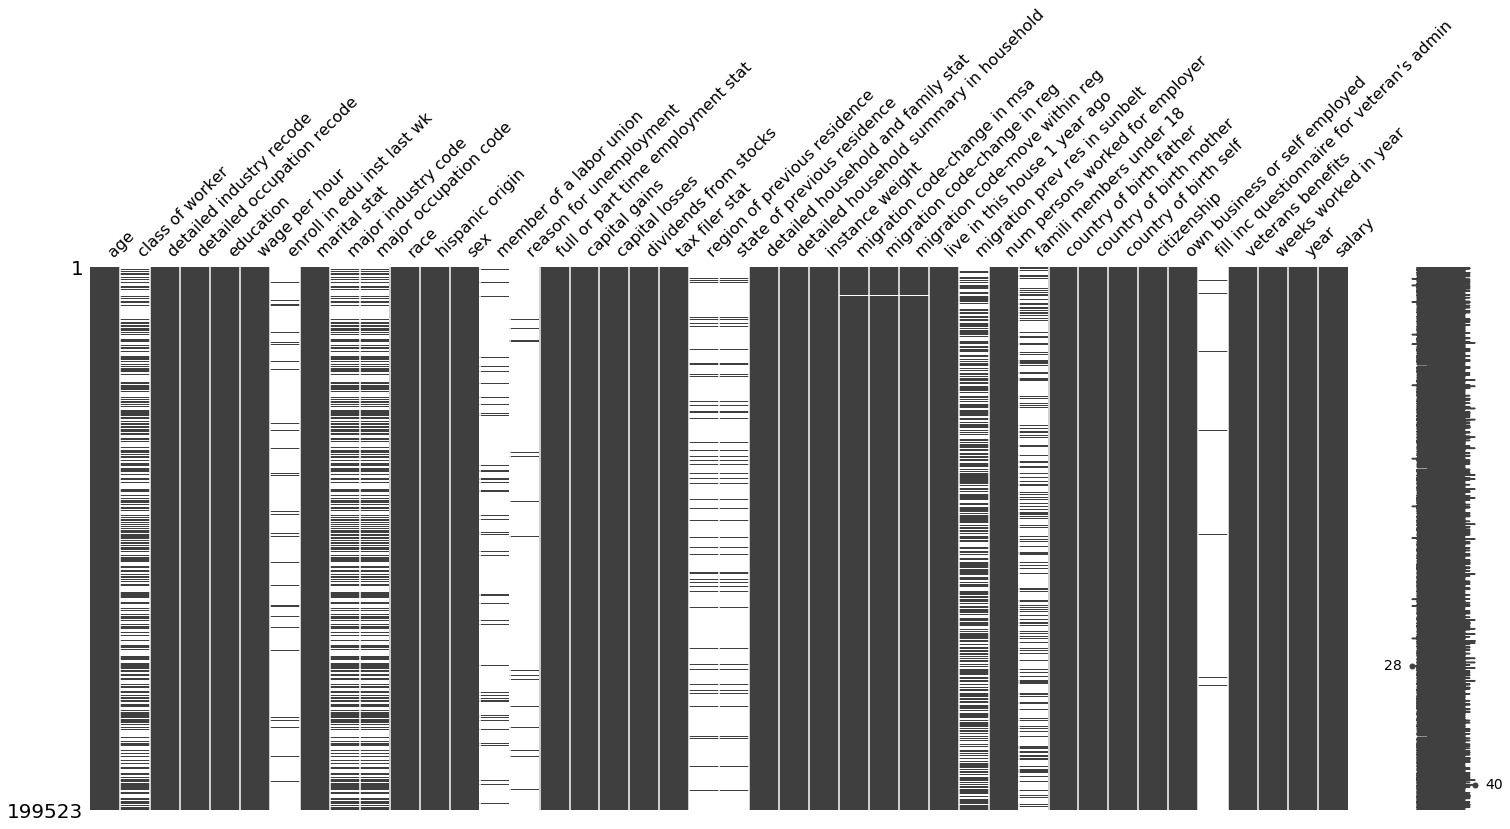

In [46]:
msno.matrix(df.sample(len(df)))

Tutaj widzę które brakujące wartości są ze sobą powiązane. Tzn. jeśli nie ma "major industry code" to nie ma również "major occupation code". Co ciekawe istnieje ujemna korelacja dla "famili member under 18". Trzeba to zbadać.

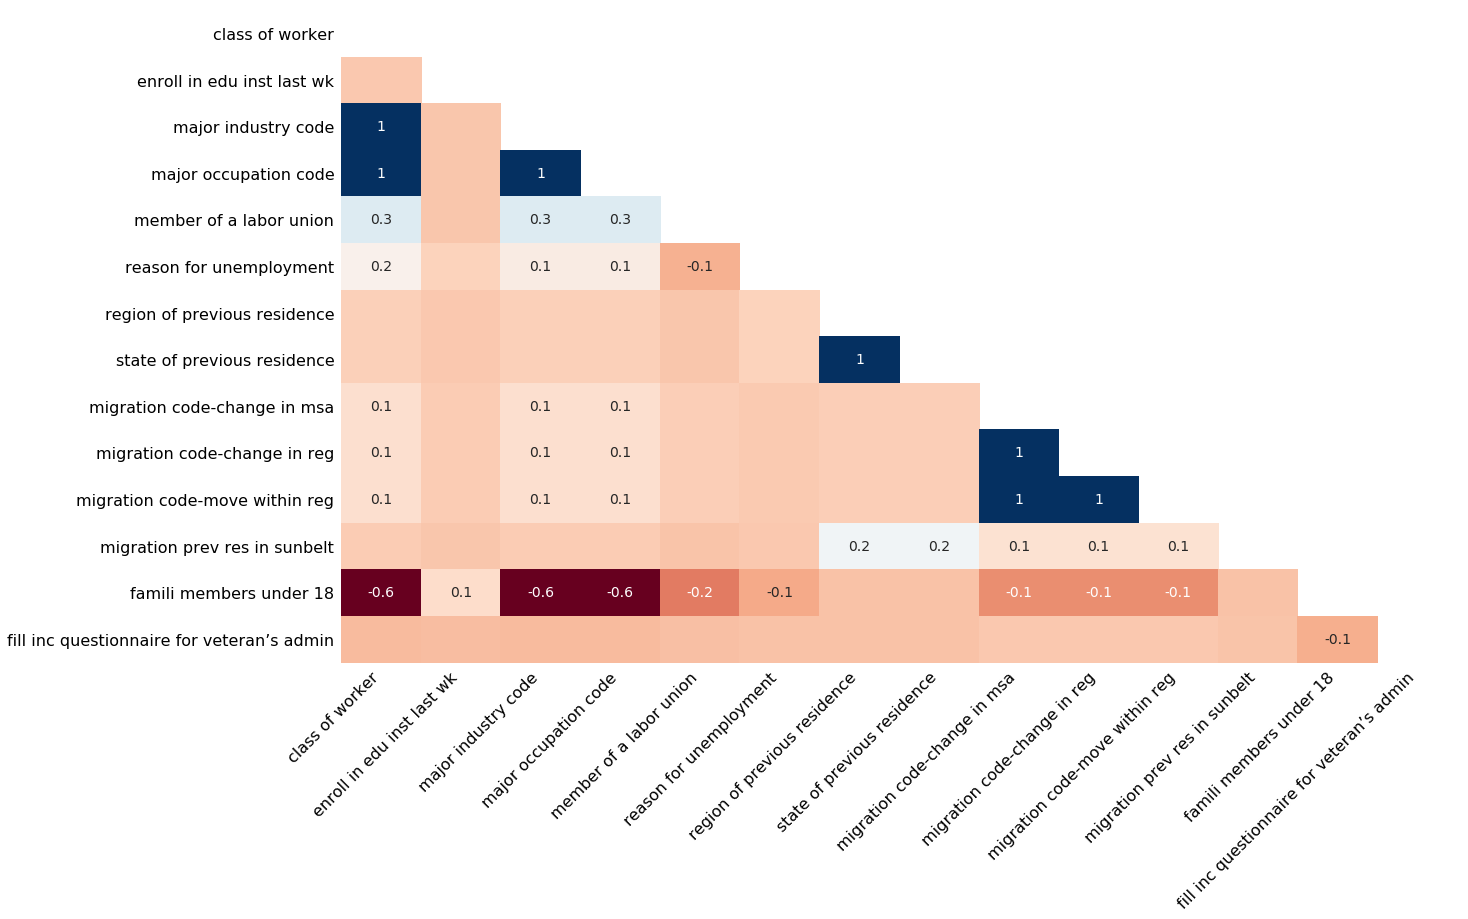

In [42]:
msno.heatmap(df)

In [47]:
df.skew(), df.kurt()

(age                                 0.373290
 detailed industry recode            0.516688
 detailed occupation recode          0.829238
 wage per hour                       8.935097
 capital gains                      18.990822
 capital losses                      7.632565
 dividends from stocks              27.786502
 instance weight                     1.432733
 num persons worked for employer     0.751561
 own business or self employed       2.912744
 veterans benefits                  -1.200994
 weeks worked in year                0.210169
 year                                0.001313
 dtype: float64, age                                  -0.732824
 detailed industry recode             -1.501108
 detailed occupation recode           -0.896533
 wage per hour                       155.218897
 capital gains                       393.062832
 capital losses                       61.632933
 dividends from stocks              1090.563754
 instance weight                       5.412514
 n

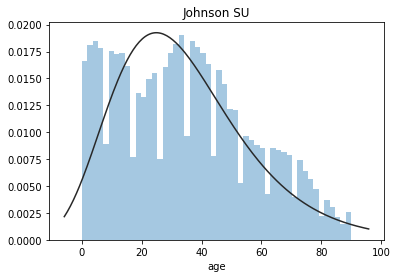

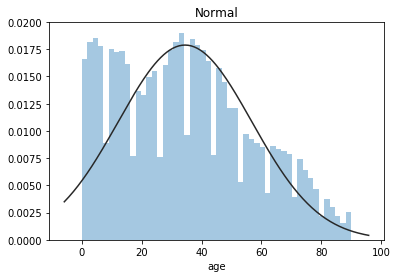

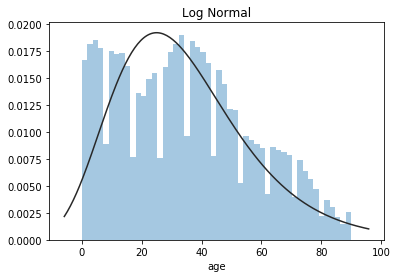

In [48]:
y = df['age']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

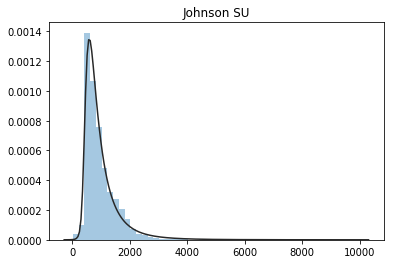

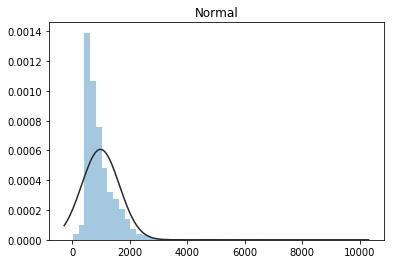

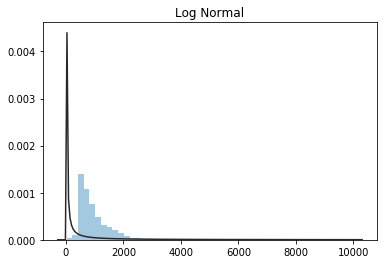

In [50]:
y = [t for t in df['wage per hour'] if t > 0] # rekordy gdzie nie ma zarobkow sa do bani
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

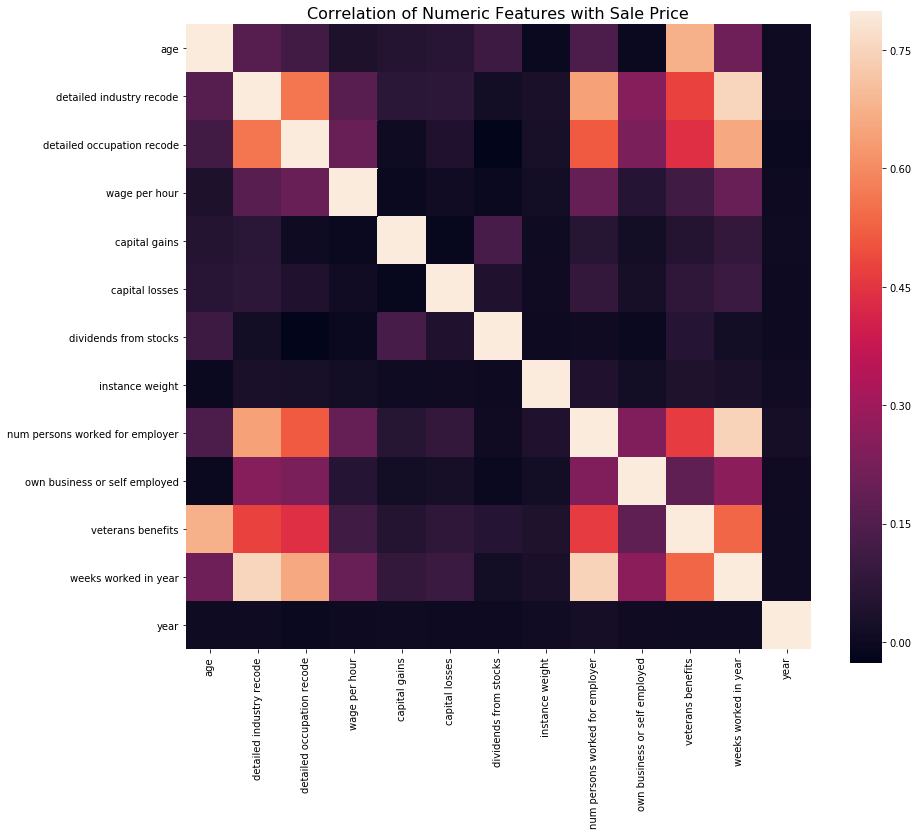

In [51]:
correlation = numeric_features.corr()
f , ax = plt.subplots(figsize = (14,12))

plt.title('Correlation of Numeric Features with Sale Price',y=1,size=16)

sns.heatmap(correlation,square = True,  vmax=0.8)